In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [42]:
# Load the dataset
 
df = pd.read_csv('final_dataset.csv')

# Convert date column to datetime
df['date'] = pd.to_datetime(df['date'])

# Prepare data for Prophet (rename columns to 'ds' and 'y')
prophet_df = df[['date', 'demand']].rename(columns={'date': 'ds', 'demand': 'y'})

# Split data into training (80%) and testing (20%)
split_idx = int(len(prophet_df) * 0.8)
train, test = prophet_df.iloc[:split_idx], prophet_df.iloc[split_idx:]


In [43]:
df=df.sort_values(by='date')
df.ffill(inplace=True)

In [44]:
df['date']=pd.to_datetime(df['date'])

In [45]:
df['day_of_week']=df['date'].dt.day_name()

In [46]:
df[['day_of_week','holiday','date']]

,day_of_week,holiday,date
0,Thursday,1,2015-01-01
1,Friday,0,2015-01-02
2,Saturday,1,2015-01-03
3,Sunday,1,2015-01-04
4,Monday,0,2015-01-05
...,...,...,...
2101,Friday,0,2020-10-02
2102,Saturday,1,2020-10-03
2103,Sunday,1,2020-10-04
2104,Monday,0,2020-10-05


<Axes: xlabel='school_day'>

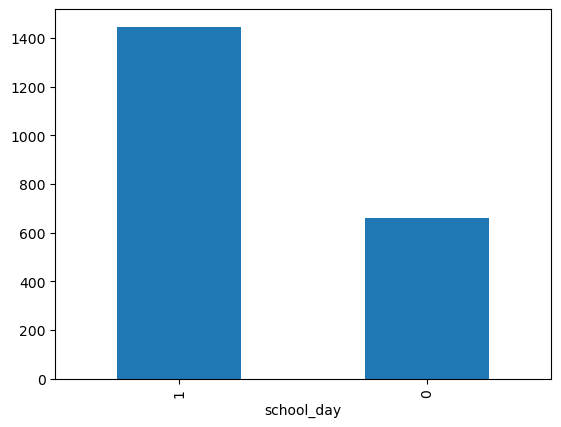

In [47]:
df['school_day'].value_counts().plot(kind='bar')

In [48]:
df

,Unnamed: 0.1,Unnamed: 0,date,demand,RRP,demand_pos_RRP,RRP_positive,demand_neg_RRP,RRP_negative,frac_at_neg_RRP,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday,weekday,day_of_week
0,0,0,2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,0,1,3,Thursday
1,1,1,2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,1,0,4,Friday
2,2,2,2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,0,1,5,Saturday
3,3,3,2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,0,1,6,Sunday
4,4,4,2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,1,0,0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,2101,2101,2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,1,0,4,Friday
2102,2102,2102,2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,0,1,5,Saturday
2103,2103,2103,2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,0,1,6,Sunday
2104,2104,2104,2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,1,0,0,Monday


In [49]:
# Initialize Prophet model
model = Prophet()

# Fit the model on the training data
model.fit(train)


15:19:52 - cmdstanpy - INFO - Chain [1] start processing
15:19:53 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
# Create a dataframe for future predictions (same length as the test set)
future = model.make_future_dataframe(periods=len(test), freq='D')

# Generate forecast
forecast = model.predict(future)

# Extract only the predicted values for the test period
test_forecast = forecast.iloc[split_idx:][['ds', 'yhat']].set_index('ds')
actual = test.set_index('ds')


In [51]:
# Compute evaluation metrics
mse = mean_squared_error(actual['y'], test_forecast['yhat'])
mae = mean_absolute_error(actual['y'], test_forecast['yhat'])
r2 = r2_score(actual['y'], test_forecast['yhat'])

print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R²): {r2:.2f}")


Mean Squared Error (MSE): 77565783.21
Mean Absolute Error (MAE): 6698.78
R-Squared (R²): 0.55


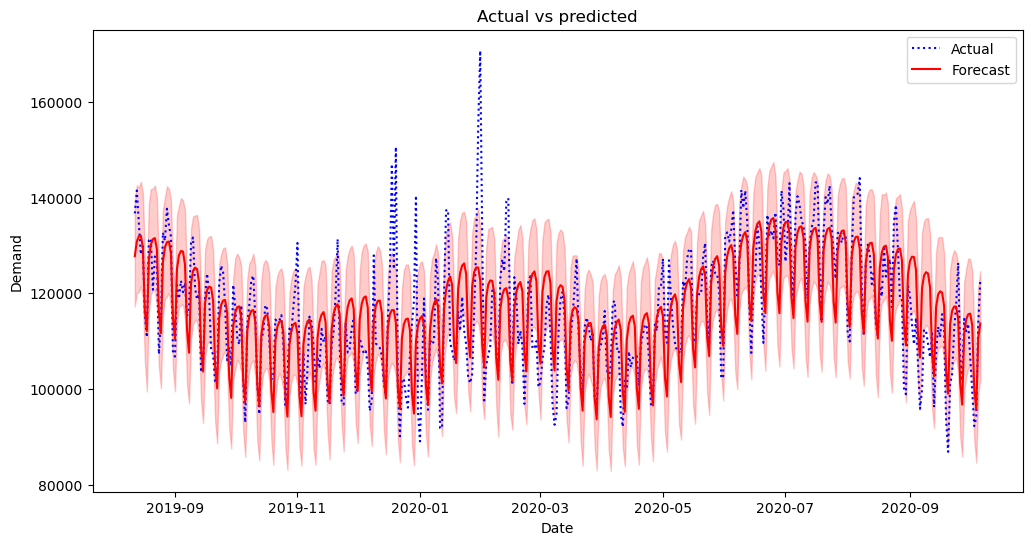

In [52]:
# Plot actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual['y'], label="Actual", color='blue', linestyle='dotted')
plt.plot(test_forecast.index, test_forecast['yhat'], label="Forecast", color='red')
plt.fill_between(test_forecast.index, 
                 forecast.iloc[split_idx:]['yhat_lower'], 
                 forecast.iloc[split_idx:]['yhat_upper'], 
                 color='red', alpha=0.2)
plt.legend()
plt.title("Actual vs predicted")
plt.xlabel("Date")
plt.ylabel("Demand")
plt.show()
